# STEP 1: Convert raw data to modeling data

The raw data is a .czi file as returned by the zeiss zen software. We need to convert the raw data to data that is more appropriate for segmentation modeling purposes (like a small .tif or .jpg file).

Data conversion process includes:

0. (Before conversion) Place raw data in data/raw

1. Convert raw czi data to (.tif) images in data/interim/converted/images

2. Label converted images with MATLAB labeling tool.

3. Split data into training, testing, and validation sets

4. Crop 2048x2048 images to 4 1024x1024 images, downsize crops to 256x256, and save to data/procesed   

## Step 1.1: Convert raw czi data to .tif images

Set the path to the input and output data directories and the desired converted image extension.

Then run the conversion script to convert all czi files in sub-directories of the input_dir. Save the files in a mirrored directory structure located in the output_dir.

Converts image at `/data/raw/date_dir/trial_name.czi` to a sequence of images at `/data/interim/converted/images/date_dir/trial_name/trial_name_XXXXXX.tif` where the XXXXXX denotes the number in the stack.

In [3]:
%load_ext autoreload
%autoreload 2

In [42]:
from src.data.convert_czi import czi_convert_directories
input_dir = "../data/raw"
output_dir = "../data/interim/converted/images"
ext = '.tif'
czi_convert_directories(input_dir=input_dir, output_dir=output_dir, overwrite=False, ext=".tif")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


INFO: Overwrite disabled, so not saving to ../data/interim/converted/images\20220504/E14 because it already exists
INFO: Overwrite disabled, so not saving to ../data/interim/converted/images\20220504/E14a because it already exists
INFO: Overwrite disabled, so not saving to ../data/interim/converted/images\20220504/E14e because it already exists
INFO: Overwrite disabled, so not saving to ../data/interim/converted/images\20220504/E14f because it already exists
INFO: Overwrite disabled, so not saving to ../data/interim/converted/images\20220504/E14h because it already exists
INFO: Overwrite disabled, so not saving to ../data/interim/converted/images\20220504/E4 b because it already exists
INFO: Overwrite disabled, so not saving to ../data/interim/converted/images\20220504/E4c because it already exists
INFO: Overwrite disabled, so not saving to ../data/interim/converted/images\20220504/E4d because it already exists
INFO: Overwrite disabled, so not saving to ../data/interim/converted/images

## Step 1.2: Label image using MATLAB labeler

This step was done previously on a small set of images that were previously converted by ImageJ bioformats importer. These images and masks are located at `"T:/Autoinjector/tissue_images/mouse/tissue_seg/tif"`
I copied the files from this directory to a new directory: `data/interim/imagej_converted`.

The copied files have filenames of the form nameXXXX.tif. I copied the directory structure of `data/interim/converted` into `data/interim/imagej_converted`. Then I simultaneously moved the files into their respective date and name directories as well as renamed to name_XXXXXX.tif to match the filenames in `data/interim/converted`.

In [3]:
import src.data._temp_directory_commands as tmp_data

tmp_data.mimic_tree("../data/interim/converted", "../data/interim/imagej_converted")
tmp_data.move_and_rename_files("../data/interim/imagej_converted/images")
tmp_data.move_and_rename_files("../data/interim/imagej_converted/masks")

### Step 1.2.1: Relabel the mask data.

The initial masks that I labeled with matlab have labels of fg = 1 and bg = 2. Relabel these to fg=1 and bg = 0

In [4]:
data_dir = "../data/interim/imagej_converted"
mask_dir = f"{data_dir}/masks"
tmp_data.relabel_binary_masks(mask_dir=mask_dir, fg_label=1, bg_label=2, ext=".tif")

Confirm the labels and images

255


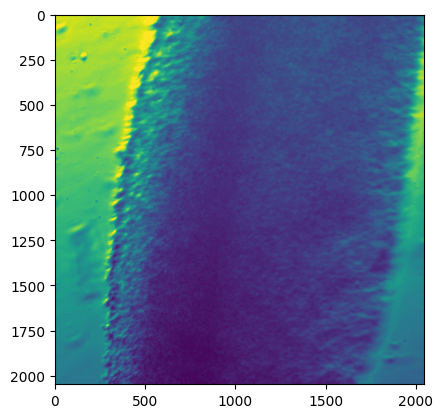

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
import tifffile
import numpy as np
ipath = f"{data_dir}/images/20220509/E17.5  a/E17.5  a_000008.tif"
mpath = f"{data_dir}/masks/20220509/E17.5  a/E17.5  a_000008.tif"
img = tifffile.imread(ipath)
print(np.amax(img))
plt.imshow(img)

[0 1]


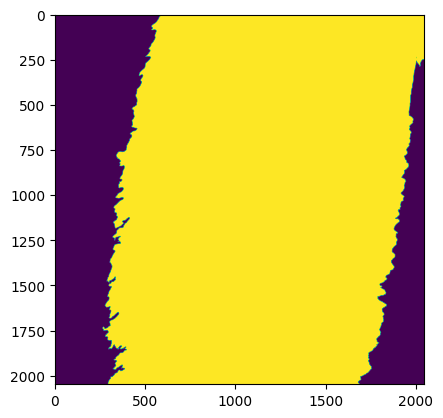

In [6]:
mpath = f"{data_dir}/masks/20220509/E17.5  a/E17.5  a_000008.tif"
img = tifffile.imread(mpath)
print(np.unique(img))
plt.imshow(img)

## Step 1.3: Split data into training, testing, and validation sets

Following steps assume you have an data directory as shown:

```
   └── interim
      └── converted_data
         ├── images
         │  ├── dir1
         │  ├── dir2
         │  ├── ...
         │  └── dirn
         └── masks
            ├── dir1
            ├── dir2
            ├── ...
            └── dirn
```

Where each `dir` has files with the same name between images<->masks. Moreover, each `dir` contains data that is related to each other; it contains an image sequence converted from a video of a single piece of tissue. So data within a `dir` should not be split into different training, testing, validation gorups.

After splitting, you will have the following data structure:
```
   └── interim
      └── converted_data
         ├── split
         │  ├── train
         │  │  ├── images
         │  │  └── masks
         │  ├── val
         │  │  ├── images
         │  │  └── masks
         │  └── test
         │     ├── images
         │     └── masks
         ├── images
         │  ├── dir1
         │  ├── dir2
         │  ├── ...
         │  └── dirn
         └── masks
            ├── dir1
            ├── dir2
            ├── ...
            └── dirn
```


In [2]:
from src.data.splitting import split_train_val_test
data_dir = "../data/interim/imagej_converted"
split_train_val_test(data_dir=data_dir, img_dir_name='images', mask_dir_name='masks', split_vals=(70,20,10), ext='.tif')

INFO: No data split because test/train/val already exsited.


## Step 1.4: Crop images and resize

Finally, take each image and crop it to a smaller size, resize it even smaller, and then save it. We downsize it drastically to reduce deep learning model overhead.

In [5]:
%load_ext autoreload
%autoreload 2
from src.data.cropping import crop_and_resize_dir
input_dir = f"{data_dir}/split"
output_dir = "../data/processed/crop_uncrop_mix"
crop_and_resize_dir(input_dir=input_dir,output_dir=output_dir, ncrops=4,size=(128,128), keep_original=True, overwrite=False, ext=".tif")

INFO: Cropping and resizing ../data/interim/imagej_converted/split\test\images/E14_000000.tif
INFO: Created directory: ../data/processed/crop_uncrop_mix\test\images
INFO: Cropping and resizing ../data/interim/imagej_converted/split\test\images/E14_000012.tif
INFO: Cropping and resizing ../data/interim/imagej_converted/split\test\images/E14_000019.tif
INFO: Cropping and resizing ../data/interim/imagej_converted/split\test\images/e15 f_000006.tif
INFO: Cropping and resizing ../data/interim/imagej_converted/split\test\images/e15 f_000013.tif
INFO: Cropping and resizing ../data/interim/imagej_converted/split\test\images/e15 f_000018.tif


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


INFO: Cropping and resizing ../data/interim/imagej_converted/split\test\images/e15 o 40x_000005.tif
INFO: Cropping and resizing ../data/interim/imagej_converted/split\test\images/e15 o 40x_000012.tif
INFO: Cropping and resizing ../data/interim/imagej_converted/split\test\images/e15 o 40x_000018.tif
INFO: Cropping and resizing ../data/interim/imagej_converted/split\test\images/E4d_000013.tif
INFO: Cropping and resizing ../data/interim/imagej_converted/split\test\images/E4d_000026.tif
INFO: Cropping and resizing ../data/interim/imagej_converted/split\test\images/E4d_000037.tif
INFO: Cropping and resizing ../data/interim/imagej_converted/split\test\masks/E14_000000.tif
INFO: Created directory: ../data/processed/crop_uncrop_mix\test\masks
INFO: Cropping and resizing ../data/interim/imagej_converted/split\test\masks/E14_000012.tif
INFO: Cropping and resizing ../data/interim/imagej_converted/split\test\masks/E14_000019.tif
INFO: Cropping and resizing ../data/interim/imagej_converted/split\te